
# 6.7-kW SyRM, saturated

This example simulates observer-based V/Hz control of a saturated 6.7-kW
synchronous reluctance motor drive. The saturation is not taken into account in
the control method (only in the system model).


In [1]:
pip install motulator

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.8/78.8 kB 2.3 MB/s eta 0:00:00


In [2]:
import numpy as np
from motulator.drive import model
import motulator.drive.control.sm as control
from motulator.drive.utils import (
    BaseValues, NominalValues, plot, Sequence, SynchronousMachinePars)

Compute base values based on the nominal values (just for figures).



In [3]:
nom = NominalValues(U=370, I=15.5, f=105.8, P=6.7e3, tau=20.1)
base = BaseValues.from_nominal(nom, n_p=2)

A saturation model is created based on [#Hin2017]_, [#Awa2018]_. For
simplicity, the saturation model parameters are hard-coded in function below,
but the same model structure can also be used for other synchronous motors.
For PM motors, the magnetomotive force (MMF) of the PMs can be modeled using
constant current source `i_f` on the d-axis [#Awa2018]_, [#Jah1986]_.
Correspondingly, this approach assumes that the MMFs of the d-axis current
and of the PMs are in series. This model cannot capture the desaturation
phenomenon of thin iron ribs, see [#Arm2009]_ for details. For such motors,
look-up tables can be used.



In [4]:
def i_s(psi_s):
    """
    Magnetic model for a 6.7-kW synchronous reluctance motor.

    Parameters
    ----------
    psi_s : complex
        Stator flux linkage (Vs).

    Returns
    -------
    complex
        Stator current (A).

    Notes
    -----
    For nonzero `i_f`, the initial value of the stator flux linkage `psi_s0`
    needs to be solved, e.g., as follows::

    from scipy.optimize import minimize_scalar
    res = minimize_scalar(
        lambda psi_d: np.abs(
                    (a_d0 + a_dd*np.abs(psi_d)**S)*psi_d - i_f))
    psi_s0 = complex(res.x)

    """
    # Parameters
    a_d0, a_dd, S = 17.4, 373., 5  # d-axis self-saturation
    a_q0, a_qq, T = 52.1, 658., 1  # q-axis self-saturation
    a_dq, U, V = 1120., 1, 0  # Cross-saturation
    i_f = 0  # MMF of PMs
    # Inverse inductance functions
    G_d = a_d0 + a_dd*np.abs(psi_s.real)**S + (
        a_dq/(V + 2)*np.abs(psi_s.real)**U*np.abs(psi_s.imag)**(V + 2))
    G_q = a_q0 + a_qq*np.abs(psi_s.imag)**T + (
        a_dq/(U + 2)*np.abs(psi_s.real)**(U + 2)*np.abs(psi_s.imag)**V)
    # Stator current
    return G_d*psi_s.real - i_f + 1j*G_q*psi_s.imag

Configure the system model.



In [5]:
mdl_par = SynchronousMachinePars(n_p=2, R_s=.54)
machine = model.SynchronousMachine(mdl_par, i_s=i_s, psi_s0=0)
# Magnetically linear SyRM model for comparison
# mdl_par = SynchronousMachinePars(
#     n_p=2, R_s=.54, L_d=37e-3, L_q=6.2e-3, psi_f=0)
# machine = model.SynchronousMachine(mdl_par)
mechanics = model.StiffMechanicalSystem(J=.015)
converter = model.VoltageSourceConverter(u_dc=540)
mdl = model.Drive(converter, machine, mechanics)

Configure the control system.



In [6]:
par = SynchronousMachinePars(n_p=2, R_s=.54, L_d=37e-3, L_q=6.2e-3, psi_f=0)
cfg = control.ObserverBasedVHzControlCfg(
    par, max_i_s=2*base.i, min_psi_s=base.psi, max_psi_s=base.psi)
ctrl = control.ObserverBasedVHzControl(par, cfg)

Set the speed reference and the external load torque.



In [7]:
# Speed reference
times = np.array([0, .125, .25, .375, .5, .625, .75, .875, 1])*8
values = np.array([0, 0, 1, 1, 0, -1, -1, 0, 0])*base.w
ctrl.ref.w_m = Sequence(times, values)
# External load torque
times = np.array([0, .125, .125, .875, .875, 1])*8
values = np.array([0, 0, 1, 1, 0, 0])*nom.tau
mdl.mechanics.tau_L = Sequence(times, values)

Create the simulation object and simulate it.



In [8]:
sim = model.Simulation(mdl, ctrl)
sim.simulate(t_stop=8)

Plot results in per-unit values. By omitting the argument `base` you can plot
the results in SI units.



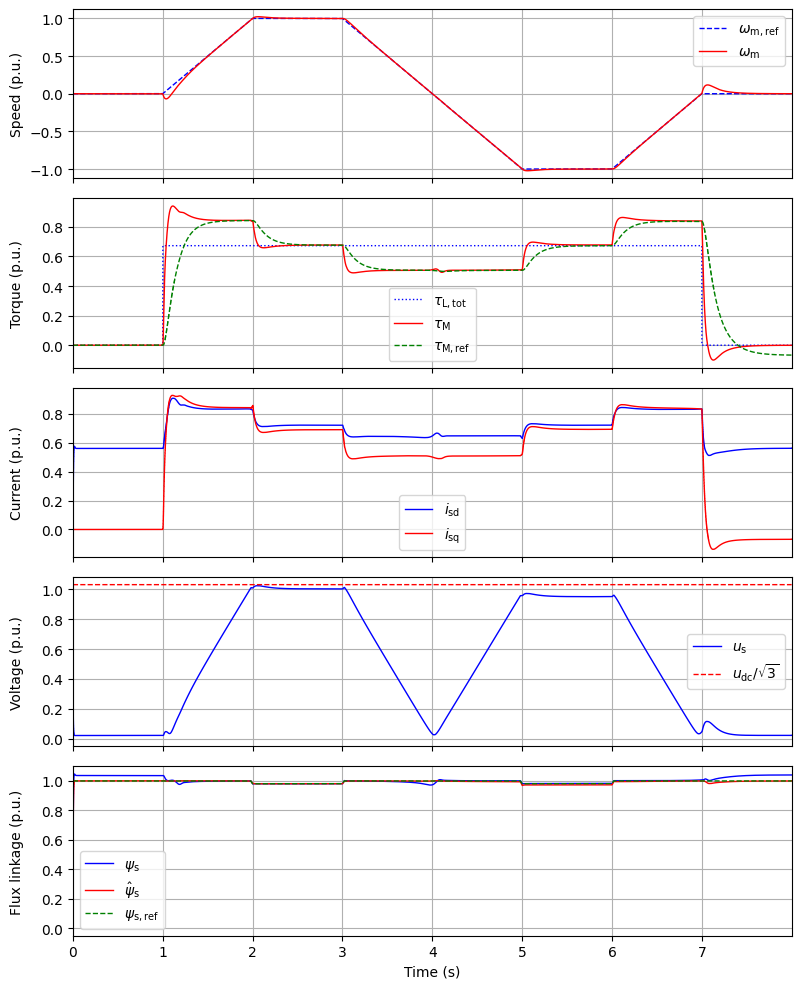

In [9]:
plot(sim, base)

.. rubric:: References

.. [#Hin2017] Hinkkanen, Pescetto, Mölsä, Saarakkala, Pellegrino, Bojoi,
   “Sensorless self-commissioning of synchronous reluctance motors at
   standstill without rotor locking, ”IEEE Trans. Ind. Appl., 2017,
   https://doi.org/10.1109/TIA.2016.2644624

.. [#Awa2018] Awan, Song, Saarakkala, Hinkkanen, "Optimal torque control of
   saturated synchronous motors: plug-and-play method," IEEE Trans. Ind.
   Appl., 2018, https://doi.org/10.1109/TIA.2018.2862410

.. [#Jah1986] Jahns, Kliman, Neumann, “Interior permanent-magnet synchronous
   motors for adjustable-speed drives,” IEEE Trans. Ind. Appl., 1986,
   https://doi.org/10.1109/TIA.1986.4504786

.. [#Arm2009] Armando, Guglielmi, Pellegrino, Pastorelli, Vagati, "Accurate
   modeling and performance analysis of IPM-PMASR motors," IEEE Trans. Ind.
   Appl., 2009, https://doi.org/10.1109/TIA.2008.2009493

